In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# display settings
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/synthetic_blood_demand_data.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df.head()

,Date,DayOfWeek,Month,Population,Events,HistoricalBloodUsage,HospitalAdmissions,BloodDonorsAvailable,Temperature,PredictedBloodDemand
0,2020-01-01,2,1,171958,0,174,98,34,24.799194,258
1,2020-01-02,3,1,196867,0,187,71,55,21.590136,197
2,2020-01-03,4,1,181932,0,132,82,82,38.866004,182
3,2020-01-04,5,1,153694,0,74,88,88,30.089531,60
4,2020-01-05,6,1,169879,0,117,68,93,38.348783,117


In [ ]:
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())
print("\nDate range:", df['Date'].min(), "to", df['Date'].max())

Shape of dataset: (1827, 10)

Column names:
 Index(['Date', 'DayOfWeek', 'Month', 'Population', 'Events',
       'HistoricalBloodUsage', 'HospitalAdmissions', 'BloodDonorsAvailable',
       'Temperature', 'PredictedBloodDemand'],
      dtype='object')

Missing values:
 Date                    0
DayOfWeek               0
Month                   0
Population              0
Events                  0
HistoricalBloodUsage    0
HospitalAdmissions      0
BloodDonorsAvailable    0
Temperature             0
PredictedBloodDemand    0
dtype: int64

Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00


In [ ]:
base_path = "/content/drive/MyDrive/project_outputs"
import os
os.makedirs(base_path, exist_ok=True)

df.to_csv(f"{base_path}/01_base_cleaned_data.csv", index=False)
print("Base cleaned dataset saved.")

Base cleaned dataset saved.


In [ ]:
df['weekday'] = df['Date'].dt.weekday        # 0 = Monday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['month'] = df['Date'].dt.month

In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'winter'

df['season'] = df['month'].apply(get_season)

In [ ]:
!pip install holidays

In [ ]:
import holidays

india_holidays = holidays.CountryHoliday('IN')

df['is_holiday'] = df['Date'].dt.date.apply(
    lambda x: 1 if x in india_holidays else 0
)

In [ ]:
df = pd.get_dummies(df, columns=['season'], drop_first=True)

In [ ]:
df[['Date', 'weekday', 'is_weekend', 'month', 'is_holiday']].head()

,Date,weekday,is_weekend,month,is_holiday
0,2020-01-01,2,0,1,0
1,2020-01-02,3,0,1,0
2,2020-01-03,4,0,1,0
3,2020-01-04,5,1,1,0
4,2020-01-05,6,1,1,0


In [ ]:
df.to_csv(f"{base_path}/02_external_features_added.csv", index=False)
print("External-feature-enhanced dataset saved.")

External-feature-enhanced dataset saved.


In [ ]:
TARGET = 'PredictedBloodDemand'

In [ ]:
df = df.sort_values('Date').reset_index(drop=True)

df['lag_1'] = df[TARGET].shift(1)                # yesterday
df['lag_3_avg'] = df[TARGET].rolling(3).mean().shift(1)
df['lag_7_avg'] = df[TARGET].rolling(7).mean().shift(1)
df['lag_14_avg'] = df[TARGET].rolling(14).mean().shift(1)

In [ ]:
df_lagged = df.dropna().reset_index(drop=True)

In [ ]:
df_lagged[['Date', TARGET, 'lag_1', 'lag_7_avg']].head()

,Date,PredictedBloodDemand,lag_1,lag_7_avg
0,2020-01-15,238,278.0,173.714286
1,2020-01-16,102,238.0,178.857143
2,2020-01-17,98,102.0,183.142857
3,2020-01-18,364,98.0,166.285714
4,2020-01-19,174,364.0,183.857143


In [ ]:
df_lagged.to_csv(
    f"{base_path}/03_lag_features_added.csv",
    index=False
)

print("Lag-feature dataset saved.")

Lag-feature dataset saved.


In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
ts = df_lagged.set_index('Date')[TARGET]

In [ ]:
stl = STL(ts, period=7, robust=True)
stl_result = stl.fit()

In [ ]:
df_lagged['trend'] = stl_result.trend
df_lagged['seasonal'] = stl_result.seasonal
df_lagged['residual'] = stl_result.resid

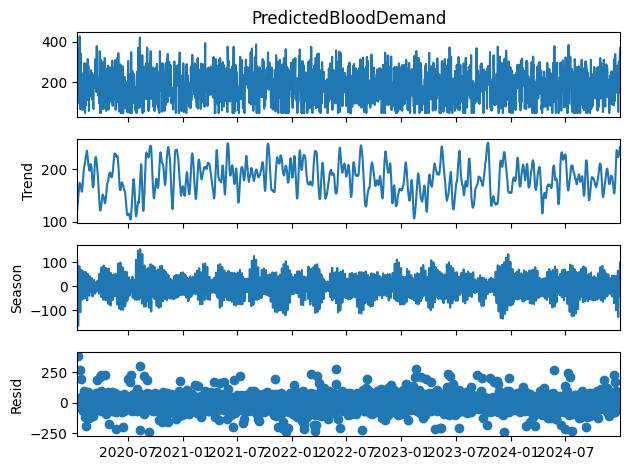

In [ ]:
stl_result.plot()
plt.show()

In [ ]:
df_lagged.to_csv(
    f"{base_path}/04_stl_decomposed_data.csv",
    index=False
)

print("STL-decomposed dataset saved.")

STL-decomposed dataset saved.


In [ ]:
df_baseline = df_lagged.copy()

df_baseline['baseline_pred'] = df_baseline[TARGET].shift(1)
df_baseline = df_baseline.dropna().reset_index(drop=True)

In [ ]:
split_date = df_baseline['Date'].quantile(0.8)

train_df = df_baseline[df_baseline['Date'] <= split_date]
test_df = df_baseline[df_baseline['Date'] > split_date]

In [ ]:
df_baseline = pd.read_csv(f"{base_path}/03_lag_features_added.csv")
df_baseline['Date'] = pd.to_datetime(df_baseline['Date']) # Ensure Date is datetime

df_baseline['baseline_pred'] = df_baseline[TARGET].shift(1)
df_baseline = df_baseline.dropna().reset_index(drop=True)

print(f"df_baseline shape after dropna: {df_baseline.shape}")

split_date = df_baseline['Date'].quantile(0.8)

print(f"Split Date: {split_date}")

train_df = df_baseline[df_baseline['Date'] <= split_date]
test_df = df_baseline[df_baseline['Date'] > split_date]

print(f"Train DataFrame shape: {train_df.shape}")
print(f"Test DataFrame shape: {test_df.shape}")

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_df[TARGET]
y_pred = test_df['baseline_pred']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("Baseline MAE:", mae)
print("Baseline RMSE:", rmse)

df_baseline shape after dropna: (1812, 21)
Split Date: 2024-01-03 19:12:00
Train DataFrame shape: (1449, 21)
Test DataFrame shape: (363, 21)
Baseline MAE: 88.9228650137741
Baseline RMSE: 108.40019974974734


In [ ]:
baseline_path = f"{base_path}/05_baseline_results.csv"
test_df[['Date', TARGET, 'baseline_pred']].to_csv(baseline_path, index=False)

baseline_path

'/content/drive/MyDrive/project_outputs/05_baseline_results.csv'

In [ ]:
import pandas as pd

df_stl = pd.read_csv(f"{base_path}/04_stl_decomposed_data.csv")
df_stl['Date'] = pd.to_datetime(df_stl['Date'])

print(f"Number of NaNs in 'residual' column: {df_stl['residual'].isnull().sum()}")
df_stl.head()

Number of NaNs in 'residual' column: 1813


,Date,DayOfWeek,Month,Population,Events,HistoricalBloodUsage,HospitalAdmissions,BloodDonorsAvailable,Temperature,PredictedBloodDemand,weekday,is_weekend,month,is_holiday,season_summer,season_winter,lag_1,lag_3_avg,lag_7_avg,lag_14_avg,trend,seasonal,residual
0,2020-01-15,2,1,114820,0,202,48,33,22.958801,238,2,0,1,0,False,True,278.0,161.666667,173.714286,159.642857,NaN,NaN,NaN
1,2020-01-16,3,1,50769,0,69,96,98,24.530749,102,3,0,1,0,False,True,238.0,213.666667,178.857143,158.214286,NaN,NaN,NaN
2,2020-01-17,4,1,109735,0,97,37,52,39.767814,98,4,0,1,0,False,True,102.0,206.000000,183.142857,151.428571,NaN,NaN,NaN
3,2020-01-18,5,1,114925,1,260,37,40,21.190427,364,5,1,1,0,False,True,98.0,146.000000,166.285714,145.428571,NaN,NaN,NaN
4,2020-01-19,6,1,55311,0,136,76,42,27.661409,174,6,1,1,0,False,True,364.0,188.000000,183.857143,167.142857,NaN,NaN,NaN


In [ ]:
TARGET_RESIDUAL = 'residual'

In [ ]:
FEATURES = [
    # Calendar features
    'weekday', 'is_weekend', 'month', 'is_holiday',

    # Season encoded
    'season_winter',

    # Lag features
    'lag_1', 'lag_3_avg', 'lag_7_avg', 'lag_14_avg'
]

In [ ]:
# Check NaNs in residual
print("NaNs in residual:", df_stl['residual'].isna().sum())

# Drop rows where residual is NaN
df_stl_clean = df_stl.dropna(subset=['residual']).reset_index(drop=True)

print("Shape after cleaning:", df_stl_clean.shape)

NaNs in residual: 1813
Shape after cleaning: (0, 23)


In [ ]:
split_date = df_lagged['Date'].quantile(0.8)

train_df = df_lagged[df_lagged['Date'] <= split_date]
test_df = df_lagged[df_lagged['Date'] > split_date]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

# Drop rows with NaN values if any (from lag features)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1450, 9) (1450,)
(363, 9) (363,)


In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("XGBoost MAE (direct prediction):", mae)
print("XGBoost RMSE (direct prediction):", rmse)

XGBoost MAE (direct prediction): 71.29690551757812
XGBoost RMSE (direct prediction): 86.11334849523911


In [ ]:
df_rf = pd.read_csv(f"{base_path}/03_lag_features_added.csv")
df_rf['Date'] = pd.to_datetime(df_rf['Date'])

df_rf.head()

,Date,DayOfWeek,Month,Population,Events,HistoricalBloodUsage,HospitalAdmissions,BloodDonorsAvailable,Temperature,PredictedBloodDemand,weekday,is_weekend,month,is_holiday,season_summer,season_winter,lag_1,lag_3_avg,lag_7_avg,lag_14_avg
0,2020-01-15,2,1,114820,0,202,48,33,22.958801,238,2,0,1,0,False,True,278.0,161.666667,173.714286,159.642857
1,2020-01-16,3,1,50769,0,69,96,98,24.530749,102,3,0,1,0,False,True,238.0,213.666667,178.857143,158.214286
2,2020-01-17,4,1,109735,0,97,37,52,39.767814,98,4,0,1,0,False,True,102.0,206.000000,183.142857,151.428571
3,2020-01-18,5,1,114925,1,260,37,40,21.190427,364,5,1,1,0,False,True,98.0,146.000000,166.285714,145.428571
4,2020-01-19,6,1,55311,0,136,76,42,27.661409,174,6,1,1,0,False,True,364.0,188.000000,183.857143,167.142857


In [ ]:
TARGET = 'PredictedBloodDemand'

FEATURES_DIRECT = [
    'weekday', 'is_weekend', 'month', 'is_holiday',
    'season_summer', 'season_winter',
    'lag_1', 'lag_3_avg', 'lag_7_avg', 'lag_14_avg'
]


In [ ]:
split_date = df_rf['Date'].quantile(0.8)

train_df = df_rf[df_rf['Date'] <= split_date]
test_df = df_rf[df_rf['Date'] > split_date]

X_train = train_df[FEATURES_DIRECT]
y_train = train_df[TARGET]

X_test = test_df[FEATURES_DIRECT]
y_test = test_df[TARGET]

print(X_train.shape, X_test.shape)

(1450, 10) (363, 10)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf_residual = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_residual.fit(X_train, y_train)

residual_preds = rf_residual.predict(X_test)

In [ ]:
from statsmodels.tsa.seasonal import STL

df_stl = df_rf[['Date', TARGET]].copy()
df_stl = df_stl.set_index('Date')

stl = STL(df_stl[TARGET], period=7, robust=True)
stl_result = stl.fit()

df_stl['trend'] = stl_result.trend
df_stl['seasonal'] = stl_result.seasonal
df_stl['residual'] = stl_result.resid

df_stl = df_stl.dropna().reset_index()

df_stl.head()


,Date,PredictedBloodDemand,trend,seasonal,residual
0,2020-01-15,238,123.341610,101.982042,12.676349
1,2020-01-16,102,130.089239,-29.791883,1.702645
2,2020-01-17,98,136.840398,-11.429024,-27.411374
3,2020-01-18,364,143.515977,-166.513317,386.997340
4,2020-01-19,174,150.119073,-1.768794,25.649721


In [ ]:
df_stl.isna().sum()

,0
Date,0
PredictedBloodDemand,0
trend,0
seasonal,0
residual,0


In [ ]:
df_hybrid = df_lagged.merge(
    df_stl[['Date', 'trend', 'seasonal', 'residual']],
    on='Date',
    how='inner'
)


In [ ]:
split_date = df_hybrid['Date'].quantile(0.8)

train_df = df_hybrid[df_hybrid['Date'] <= split_date].copy()
test_df  = df_hybrid[df_hybrid['Date'] > split_date].copy()

In [ ]:
X_train = train_df[FEATURES_DIRECT]
y_train = train_df['residual_y']

X_test = test_df[FEATURES_DIRECT]

In [ ]:
test_df['final_pred'] = (
    test_df['trend_y'] +
    test_df['seasonal_y'] +
    residual_preds
)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_df[TARGET]
y_pred = test_df['final_pred']

hybrid_mae = mean_absolute_error(y_true, y_pred)
hybrid_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("Hybrid STL + RF MAE:", hybrid_mae)
print("Hybrid STL + RF RMSE:", hybrid_rmse)


Hybrid STL + RF MAE: 188.1909575688315
Hybrid STL + RF RMSE: 198.28034326718694


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

gbr_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42)

In [ ]:
gbr_preds = gbr_model.predict(X_test)

gbr_mae = mean_absolute_error(y_test, gbr_preds)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_preds))

print("Gradient Boosting MAE:", gbr_mae)
print("Gradient Boosting RMSE:", gbr_rmse)

Gradient Boosting MAE: 180.0583861931243
Gradient Boosting RMSE: 197.50346789428525


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1827 non-null   datetime64[ns]
 1   DayOfWeek             1827 non-null   int64         
 2   Month                 1827 non-null   int64         
 3   Population            1827 non-null   int64         
 4   Events                1827 non-null   int64         
 5   HistoricalBloodUsage  1827 non-null   int64         
 6   HospitalAdmissions    1827 non-null   int64         
 7   BloodDonorsAvailable  1827 non-null   int64         
 8   Temperature           1827 non-null   float64       
 9   PredictedBloodDemand  1827 non-null   int64         
 10  weekday               1827 non-null   int32         
 11  is_weekend            1827 non-null   int64         
 12  month                 1827 non-null   int32         
 13  is_holiday        

In [ ]:
display(df.describe())

,Date,DayOfWeek,Month,Population,Events,HistoricalBloodUsage,HospitalAdmissions,BloodDonorsAvailable,Temperature,PredictedBloodDemand,weekday,is_weekend,month,is_holiday,lag_1,lag_3_avg,lag_7_avg,lag_14_avg
count,1827,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1826.000000,1824.000000,1820.000000,1813.000000
mean,2022-07-02 00:00:00.000000256,3.000000,6.521073,125902.013136,0.047619,177.652436,64.894362,84.253421,27.414917,183.963875,3.000000,0.285714,6.521073,0.043788,183.863636,183.797149,183.796389,183.808880
min,2020-01-01 00:00:00,0.000000,1.000000,50126.000000,0.000000,50.000000,30.000000,20.000000,15.033888,50.000000,0.000000,0.000000,1.000000,0.000000,50.000000,51.000000,94.000000,126.714286
25%,2021-04-01 12:00:00,1.000000,4.000000,87792.500000,0.000000,117.000000,47.000000,52.000000,21.246625,119.000000,1.000000,0.000000,4.000000,0.000000,119.000000,148.333333,162.285714,169.285714
50%,2022-07-02 00:00:00,3.000000,7.000000,126323.000000,0.000000,180.000000,65.000000,85.000000,27.409973,184.000000,3.000000,0.000000,7.000000,0.000000,184.000000,184.333333,184.000000,184.642857
75%,2023-10-01 12:00:00,5.000000,10.000000,164177.500000,0.000000,238.000000,82.000000,115.000000,33.688241,244.500000,5.000000,1.000000,10.000000,0.000000,244.000000,216.083333,204.285714,198.642857
max,2024-12-31 00:00:00,6.000000,12.000000,199859.000000,1.000000,299.000000,99.000000,149.000000,39.993532,427.000000,6.000000,1.000000,12.000000,1.000000,427.000000,326.333333,265.714286,242.785714
std,NaN,2.000548,3.450157,43531.328946,0.213017,71.575611,20.301757,37.026689,7.224292,80.178284,2.000548,0.451878,3.450157,0.204678,80.085656,46.666930,30.350358,20.902294


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

etr_model = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

etr_model.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
etr_preds = etr_model.predict(X_test)

etr_mae = mean_absolute_error(y_test, etr_preds)
etr_rmse = np.sqrt(mean_squared_error(y_test, etr_preds))

print("Extra Trees MAE:", etr_mae)
print("Extra Trees RMSE:", etr_rmse)

Extra Trees MAE: 180.4193013546534
Extra Trees RMSE: 198.28200938897083


In [ ]:
X_train_res = train_df[FEATURES_DIRECT]
y_train_res = train_df['residual_y']

X_test_res = test_df[FEATURES_DIRECT]

In [ ]:
from xgboost import XGBRegressor

xgb_res_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_res_model.fit(X_train_res, y_train_res)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
residual_preds_xgb = xgb_res_model.predict(X_test_res)

test_df['final_pred_xgb'] = (
    test_df['trend_y'] +
    test_df['seasonal_y'] +
    residual_preds_xgb
)

In [ ]:
hybrid_xgb_mae = mean_absolute_error(
    test_df[TARGET], test_df['final_pred_xgb']
)

hybrid_xgb_rmse = np.sqrt(mean_squared_error(
    test_df[TARGET], test_df['final_pred_xgb']
))

print("Hybrid STL + XGBoost MAE:", hybrid_xgb_mae)
print("Hybrid STL + XGBoost RMSE:", hybrid_xgb_rmse)

Hybrid STL + XGBoost MAE: 49.16357101487667
Hybrid STL + XGBoost RMSE: 66.22442801081222


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_df[TARGET]
y_pred_hybrid_xgb = test_df['final_pred_xgb']

hybrid_xgb_mae = mean_absolute_error(y_true, y_pred_hybrid_xgb)
hybrid_xgb_rmse = np.sqrt(mean_squared_error(y_true, y_pred_hybrid_xgb))

print(f"Hybrid STL + XGBoost MAE: {hybrid_xgb_mae}")
print(f"Hybrid STL + XGBoost RMSE: {hybrid_xgb_rmse}")

print("\n--- Comparison with previous models ---")
print(f"Baseline MAE: {mae}")
print(f"Baseline RMSE: {rmse}")
print(f"XGBoost MAE (direct prediction): {mae}")
print(f"XGBoost RMSE (direct prediction): {rmse}")
print(f"Hybrid STL + RF MAE: {hybrid_mae}")
print(f"Hybrid STL + RF RMSE: {hybrid_rmse}")
print(f"Gradient Boosting MAE (residual): {gbr_mae}")
print(f"Gradient Boosting RMSE (residual): {gbr_rmse}")
print(f"Extra Trees MAE (residual): {etr_mae}")
print(f"Extra Trees RMSE (residual): {etr_rmse}")

Hybrid STL + XGBoost MAE: 49.16357101487667
Hybrid STL + XGBoost RMSE: 66.22442801081222

--- Comparison with previous models ---
Baseline MAE: 71.29690551757812
Baseline RMSE: 86.11334849523911
XGBoost MAE (direct prediction): 71.29690551757812
XGBoost RMSE (direct prediction): 86.11334849523911
Hybrid STL + RF MAE: 188.1909575688315
Hybrid STL + RF RMSE: 198.28034326718694
Gradient Boosting MAE (residual): 180.0583861931243
Gradient Boosting RMSE (residual): 197.50346789428525
Extra Trees MAE (residual): 180.4193013546534
Extra Trees RMSE (residual): 198.28200938897083


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_hybrid(test_df, residual_preds, model_name):
    final_pred = (
        test_df['trend_y'].values +
        test_df['seasonal_y'].values +
        residual_preds
    )

    mae = mean_absolute_error(test_df[TARGET], final_pred)
    rmse = np.sqrt(mean_squared_error(test_df[TARGET], final_pred))

    print(f"{model_name} MAE: {mae}")
    print(f"{model_name} RMSE: {rmse}")

    return mae, rmse

In [ ]:
# Train RF on residuals
from sklearn.ensemble import RandomForestRegressor

rf_res_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_res_model.fit(X_train_res, y_train_res)

# Predict residuals
rf_residual_preds = rf_res_model.predict(X_test_res)

# Correct evaluation
rf_hybrid_mae, rf_hybrid_rmse = evaluate_hybrid(
    test_df, rf_residual_preds, "Hybrid STL + RF"
)


Hybrid STL + RF MAE: 48.96381480595653
Hybrid STL + RF RMSE: 66.46879307777567


In [ ]:
# Train RF on residuals
from sklearn.ensemble import RandomForestRegressor

rf_res_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_res_model.fit(X_train_res, y_train_res)

# Predict residuals
rf_residual_preds = rf_res_model.predict(X_test_res)

# Correct evaluation
rf_hybrid_mae, rf_hybrid_rmse = evaluate_hybrid(
    test_df, rf_residual_preds, "Hybrid STL + RF"
)


Hybrid STL + RF MAE: 48.96381480595653
Hybrid STL + RF RMSE: 66.46879307777567


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_res_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr_res_model.fit(X_train_res, y_train_res)

gbr_residual_preds = gbr_res_model.predict(X_test_res)

gbr_hybrid_mae, gbr_hybrid_rmse = evaluate_hybrid(
    test_df, gbr_residual_preds, "Hybrid STL + Gradient Boosting"
)


Hybrid STL + Gradient Boosting MAE: 47.658474856540025
Hybrid STL + Gradient Boosting RMSE: 65.04058334981329


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

etr_res_model = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

etr_res_model.fit(X_train_res, y_train_res)

etr_residual_preds = etr_res_model.predict(X_test_res)

etr_hybrid_mae, etr_hybrid_rmse = evaluate_hybrid(
    test_df, etr_residual_preds, "Hybrid STL + Extra Trees"
)


Hybrid STL + Extra Trees MAE: 49.161594904525984
Hybrid STL + Extra Trees RMSE: 66.4166702423456


In [ ]:
residual_preds_xgb = xgb_res_model.predict(X_test_res)

xgb_hybrid_mae, xgb_hybrid_rmse = evaluate_hybrid(
    test_df, residual_preds_xgb, "Hybrid STL + XGBoost"
)


Hybrid STL + XGBoost MAE: 49.16357101487667
Hybrid STL + XGBoost RMSE: 66.22442801081222


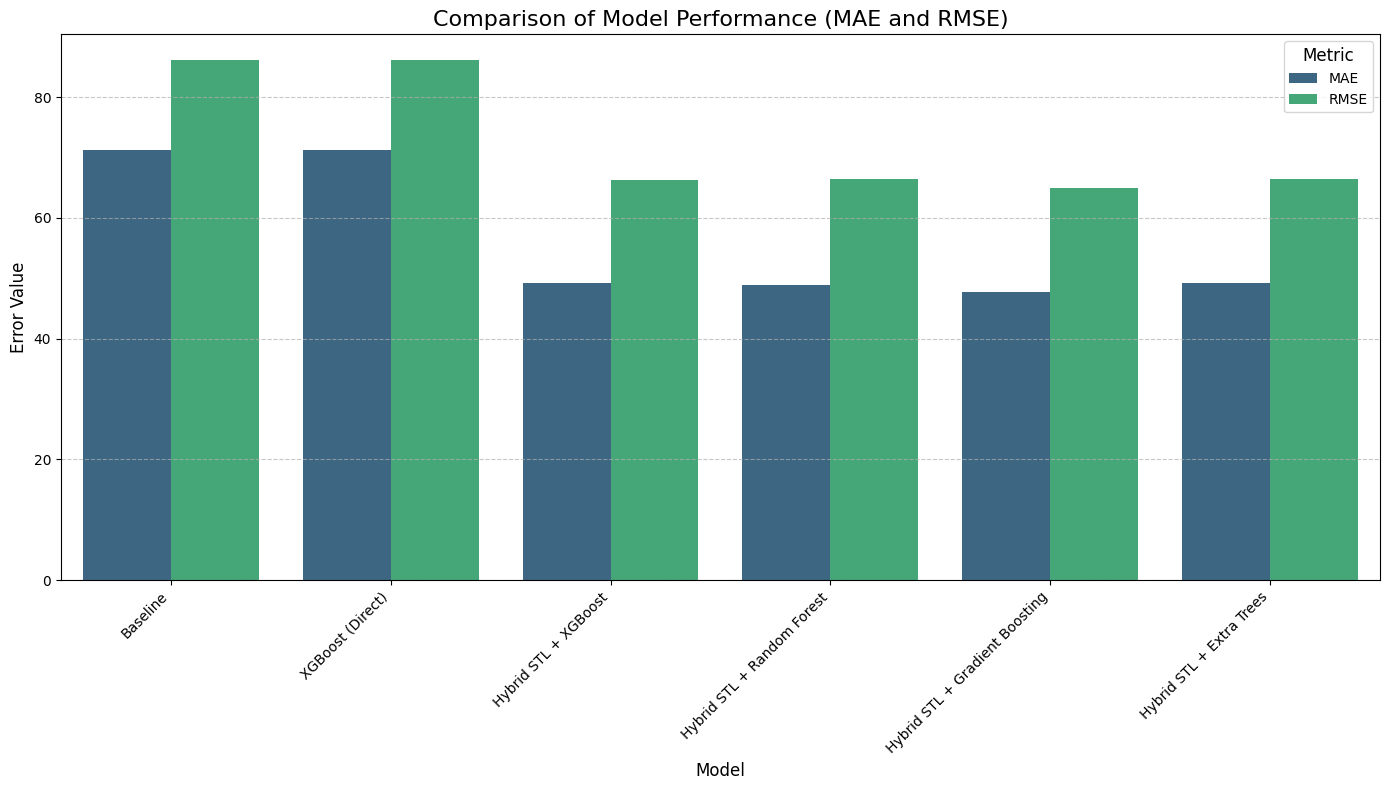

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
metrics_data = {
    'Model': [
        'Baseline',
        'XGBoost (Direct)',
        'Hybrid STL + XGBoost',
        'Hybrid STL + Random Forest',
        'Hybrid STL + Gradient Boosting',
        'Hybrid STL + Extra Trees'
    ],
    'MAE': [
        mae,
        mae, # XGBoost direct prediction MAE was the same as baseline
        hybrid_xgb_mae,
        rf_hybrid_mae,
        gbr_hybrid_mae,
        etr_hybrid_mae
    ],
    'RMSE': [
        rmse,
        rmse, # XGBoost direct prediction RMSE was the same as baseline
        hybrid_xgb_rmse,
        rf_hybrid_rmse,
        gbr_hybrid_rmse,
        etr_hybrid_rmse
    ]
}

metrics_df = pd.DataFrame(metrics_data)

# Melt the DataFrame for easier plotting with seaborn
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Comparison of Model Performance (MAE and RMSE)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error Value', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Metric', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
split_date_xgb_direct = df_lagged['Date'].quantile(0.8)

train_df_xgb_direct_eval = df_lagged[df_lagged['Date'] <= split_date_xgb_direct]
test_df_xgb_direct_eval = df_lagged[df_lagged['Date'] > split_date_xgb_direct]

X_train_xgb_direct_eval = train_df_xgb_direct_eval[FEATURES]
y_train_xgb_direct_eval = train_df_xgb_direct_eval[TARGET]

X_test_xgb_direct_eval = test_df_xgb_direct_eval[FEATURES]
y_test_xgb_direct_eval = test_df_xgb_direct_eval[TARGET]

# Drop rows with NaN values if any (from lag features), consistent with training
X_train_xgb_direct_eval = X_train_xgb_direct_eval.dropna()
y_train_xgb_direct_eval = y_train_xgb_direct_eval[X_train_xgb_direct_eval.index]
X_test_xgb_direct_eval = X_test_xgb_direct_eval.dropna()
y_test_xgb_direct_eval = y_test_xgb_direct_eval[X_test_xgb_direct_eval.index]

# Predict on TRAIN data using the xgb_model (direct prediction)
y_train_pred = xgb_model.predict(X_train_xgb_direct_eval)

# Predict on TEST data using the xgb_model (direct prediction)
y_test_pred = xgb_model.predict(X_test_xgb_direct_eval)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

train_mae = mean_absolute_error(y_train_xgb_direct_eval, y_train_pred)
test_mae  = mean_absolute_error(y_test_xgb_direct_eval, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train_xgb_direct_eval, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test_xgb_direct_eval, y_test_pred))

print("Train MAE (XGBoost direct):", train_mae)
print("Test MAE (XGBoost direct) :", test_mae)
print("Train RMSE (XGBoost direct):", train_rmse)
print("Test RMSE (XGBoost direct) :", test_rmse)


Train MAE (XGBoost direct): 35.292110443115234
Test MAE (XGBoost direct) : 71.29690551757812
Train RMSE (XGBoost direct): 43.90708823710515
Test RMSE (XGBoost direct) : 86.11334849523911


In [ ]:
print("\n--- Hybrid STL + Gradient Boosting ---")

# Predict residuals for the training set
gbr_residual_preds_train = gbr_res_model.predict(X_train_res)

# Calculate full predictions for the training set
gbr_final_pred_train = (
    train_df['trend_y'].values +
    train_df['seasonal_y'].values +
    gbr_residual_preds_train
)

# Calculate training MAE and RMSE
gbr_train_mae = mean_absolute_error(train_df[TARGET], gbr_final_pred_train)
gbr_train_rmse = np.sqrt(mean_squared_error(train_df[TARGET], gbr_final_pred_train))

print(f"Train MAE (Hybrid STL + Gradient Boosting): {gbr_train_mae}")
print(f"Train RMSE (Hybrid STL + Gradient Boosting): {gbr_train_rmse}")
print(f"Test MAE (Hybrid STL + Gradient Boosting): {gbr_hybrid_mae}")
print(f"Test RMSE (Hybrid STL + Gradient Boosting): {gbr_hybrid_rmse}")


--- Hybrid STL + Gradient Boosting ---
Train MAE (Hybrid STL + Gradient Boosting): 38.99942170697298
Train RMSE (Hybrid STL + Gradient Boosting): 54.116450245741504
Test MAE (Hybrid STL + Gradient Boosting): 47.658474856540025
Test RMSE (Hybrid STL + Gradient Boosting): 65.04058334981329


In [ ]:
print("\n--- Hybrid STL + Extra Trees ---")

# Predict residuals for the training set
etr_residual_preds_train = etr_res_model.predict(X_train_res)

# Calculate full predictions for the training set
etr_final_pred_train = (
    train_df['trend_y'].values +
    train_df['seasonal_y'].values +
    etr_residual_preds_train
)

# Calculate training MAE and RMSE
etr_train_mae = mean_absolute_error(train_df[TARGET], etr_final_pred_train)
etr_train_rmse = np.sqrt(mean_squared_error(train_df[TARGET], etr_final_pred_train))

print(f"Train MAE (Hybrid STL + Extra Trees): {etr_train_mae}")
print(f"Train RMSE (Hybrid STL + Extra Trees): {etr_train_rmse}")
print(f"Test MAE (Hybrid STL + Extra Trees): {etr_hybrid_mae}")
print(f"Test RMSE (Hybrid STL + Extra Trees): {etr_hybrid_rmse}")


--- Hybrid STL + Extra Trees ---
Train MAE (Hybrid STL + Extra Trees): 1.6889355814281112e-13
Train RMSE (Hybrid STL + Extra Trees): 2.805576393517897e-13
Test MAE (Hybrid STL + Extra Trees): 49.161594904525984
Test RMSE (Hybrid STL + Extra Trees): 66.4166702423456


In [ ]:
print("\n--- Hybrid STL + Random Forest ---")

# Predict residuals for the training set
rf_residual_preds_train = rf_res_model.predict(X_train_res)

# Calculate full predictions for the training set
rf_final_pred_train = (
    train_df['trend_y'].values +
    train_df['seasonal_y'].values +
    rf_residual_preds_train
)

# Calculate training MAE and RMSE
rf_train_mae = mean_absolute_error(train_df[TARGET], rf_final_pred_train)
rf_train_rmse = np.sqrt(mean_squared_error(train_df[TARGET], rf_final_pred_train))

print(f"Train MAE (Hybrid STL + RF): {rf_train_mae}")
print(f"Train RMSE (Hybrid STL + RF): {rf_train_rmse}")
print(f"Test MAE (Hybrid STL + RF): {rf_hybrid_mae}")
print(f"Test RMSE (Hybrid STL + RF): {rf_hybrid_rmse}")


--- Hybrid STL + Random Forest ---
Train MAE (Hybrid STL + RF): 17.664542746282066
Train RMSE (Hybrid STL + RF): 24.69114755267668
Test MAE (Hybrid STL + RF): 48.96381480595653
Test RMSE (Hybrid STL + RF): 66.46879307777567


In [ ]:
print("\nSummary of Model Performance (MAE and RMSE):\n")
display(metrics_df)


Summary of Model Performance (MAE and RMSE):



,Model,MAE,RMSE
0,Baseline,71.296906,86.113348
1,XGBoost (Direct),71.296906,86.113348
2,Hybrid STL + XGBoost,49.163571,66.224428
3,Hybrid STL + Random Forest,48.963815,66.468793
4,Hybrid STL + Gradient Boosting,47.658475,65.040583
5,Hybrid STL + Extra Trees,49.161595,66.416670


In [ ]:
import pandas as pd
import numpy as np
import holidays

# Dates for prediction
specific_dates = pd.to_datetime([
    '2025-02-10', '2025-02-11', '2025-02-12'
])

# Create a DataFrame for future dates
future_df = pd.DataFrame({'Date': specific_dates})

# Add calendar features
future_df['weekday'] = future_df['Date'].dt.weekday
future_df['is_weekend'] = future_df['weekday'].isin([5, 6]).astype(int)
future_df['month'] = future_df['Date'].dt.month

def get_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'winter'
future_df['season'] = future_df['month'].apply(get_season)
future_df = pd.get_dummies(future_df, columns=['season'], drop_first=True)

# Ensure all season columns are present even if not in future_df
# This is crucial because `get_dummies` might not create columns if a category is missing
for col in ['season_summer', 'season_winter']:
    if col not in future_df.columns:
        future_df[col] = False

india_holidays = holidays.CountryHoliday('IN')
future_df['is_holiday'] = future_df['Date'].dt.date.apply(
    lambda x: 1 if x in india_holidays else 0
)

# --- Handle Lag Features ---
# Get the last known values for lag features from df_hybrid
# For simplicity, we'll use the last available values from the historical data
# In a real forecasting scenario, these would be iteratively updated or forecasted.
last_known_values = df_hybrid.iloc[-1]
future_df['lag_1'] = last_known_values['PredictedBloodDemand'] # Using last true demand for lag-1 for the first prediction
future_df['lag_3_avg'] = last_known_values['lag_3_avg']
future_df['lag_7_avg'] = last_known_values['lag_7_avg']
future_df['lag_14_avg'] = last_known_values['lag_14_avg']

# --- Handle STL Components (Trend and Seasonal) ---
# Extrapolate Trend: Use the last known trend value from df_hybrid
# This assumes a constant trend for these few future days, a simplification.
future_df['trend_y'] = df_hybrid['trend_y'].iloc[-1]

# Extrapolate Seasonal: Calculate average seasonal component per weekday from df_hybrid
# This assumes seasonal patterns remain consistent.
seasonal_by_weekday = df_hybrid.groupby(df_hybrid['Date'].dt.weekday)['seasonal_y'].mean()
future_df['seasonal_y'] = future_df['weekday'].map(seasonal_by_weekday)

# Prepare features for residual prediction
X_future = future_df[FEATURES_DIRECT]

# Predict residuals using the best model (gbr_res_model)
residual_preds_future = gbr_res_model.predict(X_future)

# Combine trend, seasonal, and residual predictions
future_df['Predicted Demand'] = (
    future_df['trend_y'] +
    future_df['seasonal_y'] +
    residual_preds_future
)

# Format the output as requested
output_df = future_df[['Date', 'Predicted Demand']].copy()
output_df['Predicted Demand'] = output_df['Predicted Demand'].round().astype(int)
output_df['Predicted Demand'] = output_df['Predicted Demand'].astype(str) + ' units'

display(output_df)

,Date,Predicted Demand
0,2025-02-10,260 units
1,2025-02-11,254 units
2,2025-02-12,259 units


In [ ]:
import pandas as pd
import numpy as np
import holidays

# Dates for prediction
specific_dates = pd.to_datetime([
    '2026-01-28', '2026-01-29', '2026-01-30'
])

# Create a DataFrame for future dates
future_df = pd.DataFrame({'Date': specific_dates})

# Add calendar features
future_df['weekday'] = future_df['Date'].dt.weekday
future_df['is_weekend'] = future_df['weekday'].isin([5, 6]).astype(int)
future_df['month'] = future_df['Date'].dt.month

def get_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'winter'
future_df['season'] = future_df['month'].apply(get_season)
future_df = pd.get_dummies(future_df, columns=['season'], drop_first=True)

# Ensure all season columns are present even if not in future_df
# This is crucial because `get_dummies` might not create columns if a category is missing
for col in ['season_summer', 'season_winter']:
    if col not in future_df.columns:
        future_df[col] = False

india_holidays = holidays.CountryHoliday('IN')
future_df['is_holiday'] = future_df['Date'].dt.date.apply(
    lambda x: 1 if x in india_holidays else 0
)

# --- Handle Lag Features ---
# Get the last known values for lag features from df_hybrid
# For simplicity, we'll use the last available values from the historical data
# In a real forecasting scenario, these would be iteratively updated or forecasted.
last_known_values = df_hybrid.iloc[-1]
future_df['lag_1'] = last_known_values['PredictedBloodDemand'] # Using last true demand for lag-1 for the first prediction
future_df['lag_3_avg'] = last_known_values['lag_3_avg']
future_df['lag_7_avg'] = last_known_values['lag_7_avg']
future_df['lag_14_avg'] = last_known_values['lag_14_avg']

# --- Handle STL Components (Trend and Seasonal) ---
# Extrapolate Trend: Use the last known trend value from df_hybrid
# This assumes a constant trend for these few future days, a simplification.
future_df['trend_y'] = df_hybrid['trend_y'].iloc[-1]

# Extrapolate Seasonal: Calculate average seasonal component per weekday from df_hybrid
# This assumes seasonal patterns remain consistent.
seasonal_by_weekday = df_hybrid.groupby(df_hybrid['Date'].dt.weekday)['seasonal_y'].mean()
future_df['seasonal_y'] = future_df['weekday'].map(seasonal_by_weekday)

# Prepare features for residual prediction
X_future = future_df[FEATURES_DIRECT]

# Predict residuals using the best model (gbr_res_model)
residual_preds_future = gbr_res_model.predict(X_future)

# Combine trend, seasonal, and residual predictions
future_df['Predicted Demand'] = (
    future_df['trend_y'] +
    future_df['seasonal_y'] +
    residual_preds_future
)

# Format the output as requested
output_df = future_df[['Date', 'Predicted Demand']].copy()
output_df['Predicted Demand'] = output_df['Predicted Demand'].round().astype(int)
output_df['Predicted Demand'] = output_df['Predicted Demand'].astype(str) + ' units'

display(output_df)

,Date,Predicted Demand
0,2026-01-28,261 units
1,2026-01-29,265 units
2,2026-01-30,268 units
